In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# importing all libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from collections import Counter
import numpy as np
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

## Functions

In [2]:
labels = ["Level 1", "Level 2", "Level 3"] #, "Level 4", "Level 5"]

def plot_confusion_matrix(confusion_matrix, labels):
    fig, ax = plt.subplots()
    im = ax.imshow(confusion_matrix, cmap='Blues')

    # Set labels
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations
    for i in range(len(labels)):
        for j in range(len(labels)):
            text = ax.text(j, i, confusion_matrix[i, j], ha="center", va="center", color="black")

    # Set colorbar
    cbar = ax.figure.colorbar(im, ax=ax)

    # Set title and labels
    ax.set_title("Confusion Matrix")
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")

    # Show the plot
    plt.show()


from sklearn.metrics import classification_report, confusion_matrix

def evaluation(y_train_pred, y_test_pred, y_train, y_test):
  print("train_evaluation:\n")
  print(classification_report(y_train_pred, y_train))
  print(confusion_matrix(y_train_pred, y_train))
  print("\ntest_evaluation:\n")
  print(classification_report(y_test_pred, y_test))
  print(confusion_matrix(y_test_pred, y_test))
  plot_confusion_matrix(confusion_matrix(y_test_pred, y_test), labels)


# Level1 + Level2 -> Level1, Level3->Level2, Level4+Level5 -> Level3
def club_class(class_var):
    if class_var == 'Level 1' or class_var == 'Level 2':
        return 'Level 1'
    elif class_var == 'Level 3' or class_var == 'Level 4':
        return 'Level 2'
    else:
        return 'Level 3'


In [41]:
def model(data, test_size = 0.2, use_smote_technique=1):
    
    data1 = data

    # Seperate the target variable 
    X = data1.drop(columns = ['level'])
    y = data1['level']

    data1['level'].value_counts()

    # Split the data into test and train
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = 2, stratify = y)
    y_train = y_train.apply(club_class)
    print(y_train.value_counts())
    
    y_test = y_test.apply(club_class)
    print(y_test.value_counts())

    # Smote the data
    if use_smote_technique == 1:
        # Count the class distribution before applying SMOTE
        print("Class distribution before SMOTE:", Counter(y_train))

        # Apply SMOTE to the dataset
        smote = SMOTE(random_state=42)
        X_train, y_train = smote.fit_resample(X_train, y_train)

        # Count the class distribution after applying SMOTE
        print("Class distribution after SMOTE:", Counter(y_train))

    # Random Forest Classifier - Machine Learning Model
    rfc=RandomForestClassifier(n_jobs=-1, random_state=42, n_estimators=15)
    param_grid = {
        'max_depth': [3, 5, 7],                      # Maximum depth of the tree
        'min_samples_split': [2, 5, 10],             # Minimum number of samples required to split a node
        'min_samples_leaf': [1, 2, 3],               # Minimum number of samples required at a leaf node
        'max_features': ['auto', 'sqrt', 'log2'],    # Number of features to consider at each split
        'criterion': ['gini', 'entropy', 'log_loss'],
        'oob_score': [True],
        # 'n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200]
        # 'class_weight': ['balanced', 'balanced_subsample']    
    }


    # Perform grid search to find the best combination of parameters
    grid_search = GridSearchCV(rfc, param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    # Obtain the best values and best score
    print("Best Parameters: ", grid_search.best_params_)
    print("Best Score: ", grid_search.best_score_)

    # Evaluation of model
    y_test_pred = grid_search.best_estimator_.predict(X_test)
    y_train_pred = grid_search.best_estimator_.predict(X_train)
    evaluation(y_train_pred, y_test_pred, y_train, y_test)

    # obtain Best Features
    best_model = grid_search.best_estimator_
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]

    print("Feature Importance Rankings:")
    for i, feature in enumerate(X.columns[indices]):
        print(f"{i + 1}. {feature}: {importances[indices[i]] * 100}")

## Reading input

In [30]:
math_problems = pd.read_csv("../Data/total_data.csv", index_col=0)
math_problems.head()

,problem,level,type,modified_problem,no_of_equations,no_of_variables,has_exp,has_mod,has_logarithm,has_fraction,...,words_per_sentence_cat,average_word_length_cat,large_words_cat,number_of_math_vocab,number_of_digits,number_of_numbers,pron_words_ratio,pron_sents_ratio,adj_sents_ratio,adj_words_ratio
0,Kevin Kangaroo begins hopping on a number line...,Level 5,Algebra,Kevin Kangaroo begins hopping on a number line...,2,1,False,False,False,True,...,2,1,4,2,2,2,0.005,0.25,2.000,0.038
1,The ratio of the areas of two squares is $\fra...,Level 4,Algebra,The ratio of the areas of two squares is . Aft...,3,5,True,False,False,True,...,3,1,4,4,0,0,0.044,1.00,1.333,0.059
2,"If $\sqrt{2\sqrt{t-2}} = \sqrt[4]{7 - t}$, the...",Level 4,Algebra,"If , then find .",1,2,True,False,False,False,...,0,0,0,0,4,4,0.083,1.00,1.000,0.083
3,Let $t(x) = \sqrt{3x+1}$ and $f(x)=5-t(x)$. Wh...,Level 4,Algebra,Let and . What is ?,3,3,True,False,False,False,...,0,0,0,0,1,1,0.000,0.00,0.000,0.000
4,James has a total of 66 dollars in his piggy b...,Level 2,Algebra,James has a total of 66 dollars in his piggy b...,0,0,False,False,False,False,...,3,0,0,2,0,0,0.059,1.00,0.000,0.000


In [ ]:
# math_problems['level'] = math_problems['level'].apply(club_class)

In [31]:
size_mapping = {"Prealgebra": 1, "Intermediate Algebra": 2, "Algebra": 3}
math_problems['type'] = math_problems['type'].replace(size_mapping)

In [36]:
NER_FEATURES = ['CARDINAL',
 'DATE',
 'EVENT',
 'FAC',
 'GPE',
 'LANGUAGE',
 'LAW',
 'LOC',
 'MONEY',
 'NORP',
 'ORDINAL',
 'ORG',
 'PERCENT',
 'PERSON',
 'PRODUCT',
 'QUANTITY',
 'TIME',
 'WORK_OF_ART']

POS_FEATURES = ['ADJ', 'ADP', 'ADV', 'AUX', 'CONJ', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X']

LINGUISTIC_CAT_FEATURES = ['sentence_count_cat', 'word_count_cat', 'words_per_sentence_cat', 'average_word_length_cat', 'large_words_cat']

LINGUISTIC_NUM_FEATURES = ['sentence_count', 'word_count', 'words_per_sentence', 'average_word_length', 'large_words']

CONDENSED_LINGUISTIC_FEATURES = ['pron_words_ratio', 'pron_sents_ratio', 'adj_sents_ratio',	'adj_words_ratio']

MATH_CAT_FEATURES = ['has_exp', 'has_mod', 'has_logarithm', 'has_fraction', 'has_eq', 'has_neq']

MATH_NUM_FEATURES = ['exp_count', 'mod_count', 'log_count', 'fracs_count', 'eqlts_count', 'neqlts_count', 'max_degree_of_equations', 'number_of_digits', 'number_of_numbers']

MANDATORY_FEATURES = ['no_of_equations', 'no_of_variables', 'type']

MATH_VOCAB_FEATURES = ['number_of_math_vocab']

TARGET_FEATURE = ['level']

## Experiment 1: 

Consider the following features

1. Categorised linguistic features
2. Categorical math features (eg: has_exp, has_log)
3. no_of_equations
4. no_of_variables

Run Random forest for the default 5 level classification and report the results

In [33]:
data1 = math_problems[LINGUISTIC_CAT_FEATURES + MATH_CAT_FEATURES + MANDATORY_FEATURES + TARGET_FEATURE]

Level 2    1540
Level 1     955
Level 3     893
Name: level, dtype: int64
Level 2    386
Level 1    239
Level 3    223
Name: level, dtype: int64
Class distribution before SMOTE: Counter({'Level 2': 1540, 'Level 1': 955, 'Level 3': 893})
Class distribution after SMOTE: Counter({'Level 2': 1540, 'Level 1': 1540, 'Level 3': 1540})
Best Parameters:  {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'oob_score': True}
Best Score:  0.5424242424242425
train_evaluation:

              precision    recall  f1-score   support

     Level 1       0.79      0.62      0.69      1961
     Level 2       0.33      0.61      0.43       833
     Level 3       0.70      0.59      0.64      1826

    accuracy                           0.60      4620
   macro avg       0.60      0.61      0.59      4620
weighted avg       0.67      0.60      0.62      4620

[[1211  482  268]
 [ 125  509  199]
 [ 204  549 107

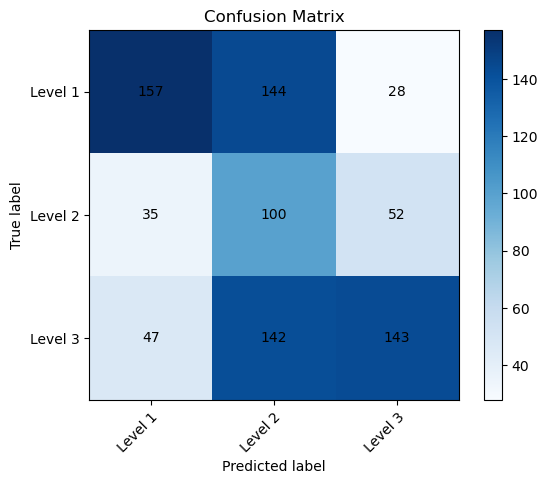

Feature Importance Rankings:
1. no_of_variables: 21.046010214116446
2. large_words_cat: 13.899318783671088
3. no_of_equations: 12.634904859418326
4. word_count_cat: 12.198924852958653
5. average_word_length_cat: 8.343746536611139
6. words_per_sentence_cat: 8.161081601500621
7. type: 6.605957643265676
8. has_exp: 6.021195067374982
9. has_fraction: 3.3535960399254807
10. sentence_count_cat: 2.7185683654934167
11. has_neq: 1.6786633655728138
12. has_mod: 1.252952258376821
13. has_eq: 1.2129796491409572
14. has_logarithm: 0.8721007625735746


In [34]:
model(data1)

Level 2    1540
Level 1     955
Level 3     893
Name: level, dtype: int64
Level 2    386
Level 1    239
Level 3    223
Name: level, dtype: int64
Best Parameters:  {'criterion': 'gini', 'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 10, 'oob_score': True}
Best Score:  0.5174176372422148
train_evaluation:

              precision    recall  f1-score   support

     Level 1       0.45      0.65      0.53       666
     Level 2       0.82      0.54      0.65      2311
     Level 3       0.30      0.64      0.40       411

    accuracy                           0.58      3388
   macro avg       0.52      0.61      0.53      3388
weighted avg       0.68      0.58      0.60      3388

[[ 430  179   57]
 [ 483 1256  572]
 [  42  105  264]]

test_evaluation:

              precision    recall  f1-score   support

     Level 1       0.38      0.53      0.44       171
     Level 2       0.72      0.47      0.57       582
     Level 3       0.19      0.45      

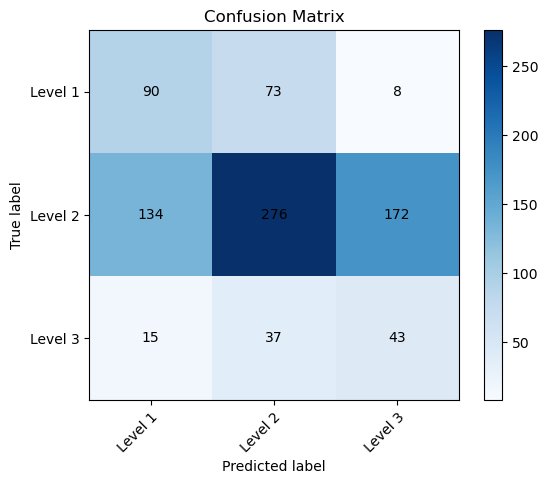

Feature Importance Rankings:
1. no_of_variables: 19.931985680449646
2. large_words_cat: 14.066191028328298
3. word_count_cat: 12.936115545966242
4. no_of_equations: 11.853930247614024
5. words_per_sentence_cat: 9.563414290231526
6. average_word_length_cat: 7.901564966632059
7. type: 5.964939431068803
8. has_exp: 5.52197868995306
9. sentence_count_cat: 4.139815221000333
10. has_fraction: 2.6237029072599545
11. has_neq: 2.542399725719195
12. has_mod: 1.4857457419714404
13. has_eq: 1.1284856299288222
14. has_logarithm: 0.3397308938766131


In [42]:
model(data1, use_smote_technique=0)

## Experiment 2: 

Consider the following features

1. Categorised linguistic features
2. All numerical math features

Run Random forest with default 5 class classification and report the results

In [37]:
data2 = math_problems[LINGUISTIC_CAT_FEATURES + MATH_NUM_FEATURES + MANDATORY_FEATURES + TARGET_FEATURE]

Level 2    1540
Level 1     955
Level 3     893
Name: level, dtype: int64
Level 2    386
Level 1    239
Level 3    223
Name: level, dtype: int64
Class distribution before SMOTE: Counter({'Level 2': 1540, 'Level 1': 955, 'Level 3': 893})
Class distribution after SMOTE: Counter({'Level 2': 1540, 'Level 1': 1540, 'Level 3': 1540})
Best Parameters:  {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'oob_score': True}
Best Score:  0.5484848484848486
train_evaluation:

              precision    recall  f1-score   support

     Level 1       0.77      0.63      0.69      1891
     Level 2       0.39      0.61      0.47       972
     Level 3       0.69      0.61      0.65      1757

    accuracy                           0.62      4620
   macro avg       0.62      0.62      0.60      4620
weighted avg       0.66      0.62      0.63      4620

[[1184  438  269]
 [ 175  596  201]
 [ 181  506 1070]]

test_

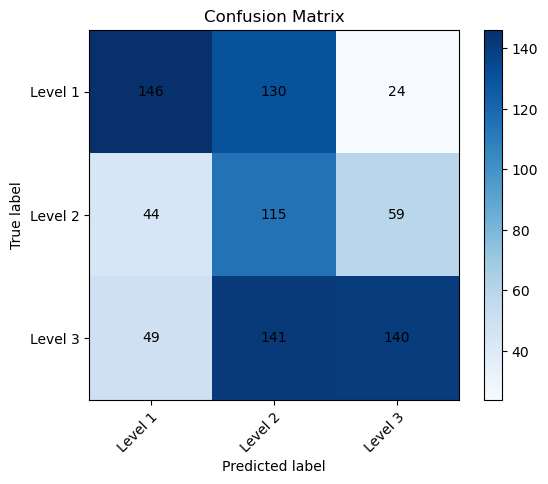

Feature Importance Rankings:
1. no_of_variables: 14.040182146474281
2. large_words_cat: 13.475996668883191
3. word_count_cat: 9.959312204172065
4. words_per_sentence_cat: 8.430882452897437
5. no_of_equations: 8.401171418134954
6. max_degree_of_equations: 7.8162266661172835
7. exp_count: 7.518667615153668
8. number_of_digits: 6.151660603637589
9. average_word_length_cat: 6.1137846426025675
10. number_of_numbers: 5.117472244234835
11. type: 4.537011018690299
12. fracs_count: 2.8906794692158617
13. sentence_count_cat: 2.3242229322280554
14. neqlts_count: 1.1971487532630083
15. eqlts_count: 0.8091492030473588
16. mod_count: 0.7913372890115107
17. log_count: 0.4250946722360456


In [38]:
model(data2)

Level 2    1540
Level 1     955
Level 3     893
Name: level, dtype: int64
Level 2    386
Level 1    239
Level 3    223
Name: level, dtype: int64
Best Parameters:  {'criterion': 'gini', 'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'oob_score': True}
Best Score:  0.5144656061140813
train_evaluation:

              precision    recall  f1-score   support

     Level 1       0.47      0.66      0.55       682
     Level 2       0.83      0.56      0.67      2276
     Level 3       0.34      0.71      0.46       430

    accuracy                           0.60      3388
   macro avg       0.55      0.64      0.56      3388
weighted avg       0.69      0.60      0.62      3388

[[ 449  176   57]
 [ 475 1272  529]
 [  31   92  307]]

test_evaluation:

              precision    recall  f1-score   support

     Level 1       0.36      0.53      0.43       162
     Level 2       0.73      0.48      0.57       589
     Level 3       0.22      0.52      0

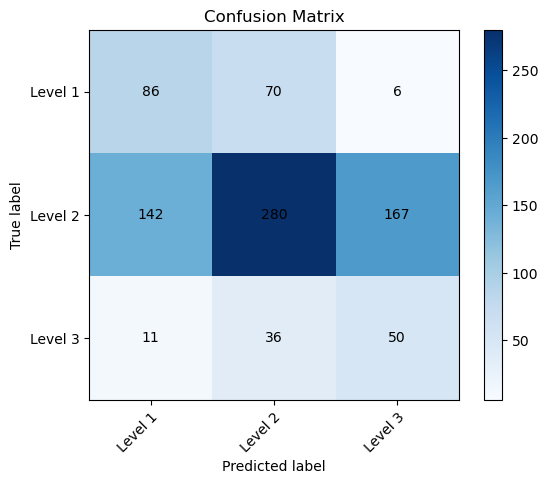

Feature Importance Rankings:
1. no_of_variables: 13.479397347461875
2. large_words_cat: 12.452416974833191
3. word_count_cat: 9.52430184925735
4. no_of_equations: 8.556482408023932
5. max_degree_of_equations: 7.481217430417894
6. number_of_digits: 7.1766065789283555
7. words_per_sentence_cat: 6.2161465928706665
8. average_word_length_cat: 6.065639196867992
9. number_of_numbers: 6.063576275147752
10. exp_count: 6.0192036735146
11. type: 4.6826145523138925
12. fracs_count: 4.197953524304124
13. sentence_count_cat: 3.3011032121260255
14. neqlts_count: 2.0682950720720243
15. eqlts_count: 1.4038453184190094
16. mod_count: 0.9953492461689318
17. log_count: 0.3158507472723956


In [43]:
model(data2, use_smote_technique=0)

## Experiment 3: 

Consider the following features

1. Categorised linguistic features
2. Categorical math features
3. POS features
4. no_of_equations
5. no_of_variables

Run Random Forest on the default 5 class classification and report the results



In [44]:
data3 = math_problems[LINGUISTIC_CAT_FEATURES + MATH_CAT_FEATURES + POS_FEATURES + MANDATORY_FEATURES + TARGET_FEATURE]

Level 2    1540
Level 1     955
Level 3     893
Name: level, dtype: int64
Level 2    386
Level 1    239
Level 3    223
Name: level, dtype: int64
Class distribution before SMOTE: Counter({'Level 2': 1540, 'Level 1': 955, 'Level 3': 893})
Class distribution after SMOTE: Counter({'Level 2': 1540, 'Level 1': 1540, 'Level 3': 1540})
Best Parameters:  {'criterion': 'entropy', 'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'oob_score': True}
Best Score:  0.5658008658008657
train_evaluation:

              precision    recall  f1-score   support

     Level 1       0.80      0.64      0.71      1942
     Level 2       0.41      0.66      0.50       944
     Level 3       0.72      0.64      0.68      1734

    accuracy                           0.64      4620
   macro avg       0.64      0.65      0.63      4620
weighted avg       0.69      0.64      0.66      4620

[[1237  440  265]
 [ 151  625  168]
 [ 152  475 1107]]

test_evaluation:

              

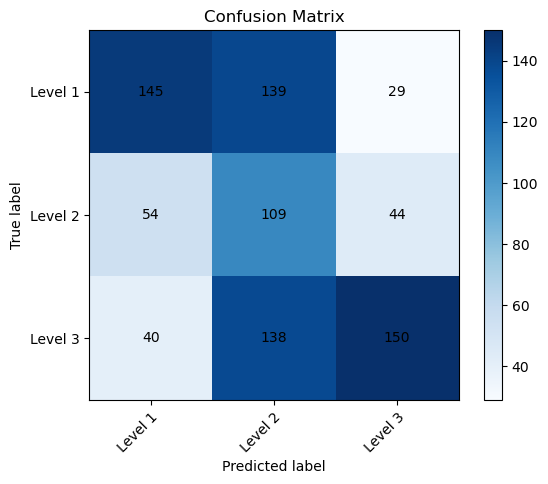

Feature Importance Rankings:
1. no_of_variables: 14.52153715797023
2. no_of_equations: 7.944912621417756
3. ADJ: 7.173156463805406
4. VERB: 6.900498664891678
5. large_words_cat: 6.216299497578706
6. NOUN: 5.4812581471735635
7. DET: 5.401797673938239
8. PUNCT: 5.075418066197736
9. word_count_cat: 4.460630964672825
10. AUX: 3.8433246953730147
11. words_per_sentence_cat: 3.6725169636047266
12. ADP: 3.6269430944752012
13. has_exp: 3.276116297192308
14. average_word_length_cat: 2.9658931831554827
15. type: 2.3380053626402795
16. NUM: 2.1291403283758568
17. CCONJ: 2.0511687676114185
18. PRON: 1.9764262076231034
19. PROPN: 1.9335936807698202
20. SCONJ: 1.8810870174149845
21. has_fraction: 1.582619655483674
22. ADV: 1.2258421883436983
23. has_neq: 0.7610966922800081
24. has_eq: 0.7561324085920501
25. PART: 0.7073686215776201
26. X: 0.6227511929452284
27. sentence_count_cat: 0.43071093709559627
28. SYM: 0.38236404017269854
29. has_logarithm: 0.37481015312093785
30. has_mod: 0.2865792545061591
3

In [45]:
model(data3)

Level 2    1540
Level 1     955
Level 3     893
Name: level, dtype: int64
Level 2    386
Level 1    239
Level 3    223
Name: level, dtype: int64
Best Parameters:  {'criterion': 'entropy', 'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'oob_score': True}
Best Score:  0.5301089746103538
train_evaluation:

              precision    recall  f1-score   support

     Level 1       0.53      0.71      0.61       704
     Level 2       0.83      0.58      0.68      2209
     Level 3       0.40      0.75      0.52       475

    accuracy                           0.63      3388
   macro avg       0.59      0.68      0.60      3388
weighted avg       0.71      0.63      0.65      3388

[[ 502  160   42]
 [ 430 1284  495]
 [  23   96  356]]

test_evaluation:

              precision    recall  f1-score   support

     Level 1       0.40      0.58      0.47       163
     Level 2       0.72      0.49      0.58       564
     Level 3       0.28      0.51    

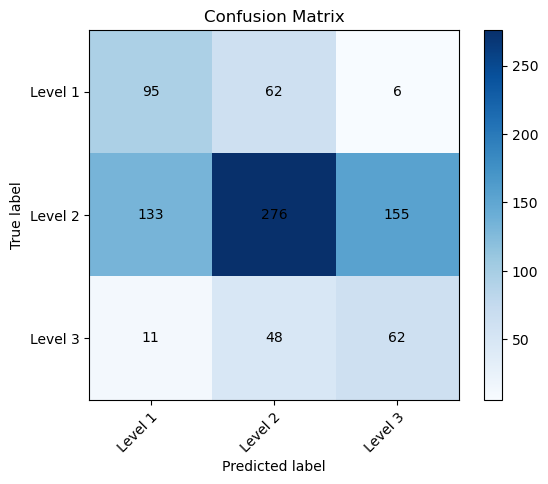

Feature Importance Rankings:
1. no_of_variables: 13.230354268560246
2. ADJ: 8.197298498058423
3. no_of_equations: 6.990348197628279
4. ADP: 5.825806390352425
5. DET: 5.731407171821779
6. NOUN: 5.614624587680482
7. large_words_cat: 5.6111957592846196
8. PUNCT: 5.17529764226764
9. VERB: 5.010351327138518
10. word_count_cat: 3.840929912514236
11. has_exp: 3.519407417241905
12. average_word_length_cat: 3.5070368147444513
13. words_per_sentence_cat: 2.682622616545967
14. type: 2.637659336482625
15. CCONJ: 2.4562476052096316
16. NUM: 2.3591990330716723
17. SCONJ: 2.352311495239569
18. ADV: 2.2509069816916845
19. PRON: 2.2063564529754784
20. AUX: 1.9571494829269576
21. PROPN: 1.8648980490513378
22. X: 1.3245726087932115
23. has_fraction: 1.2255923410016352
24. has_neq: 1.0319126370000844
25. PART: 0.9752220652419976
26. sentence_count_cat: 0.7401179248487674
27. has_eq: 0.6270309508724875
28. SYM: 0.4929826380619115
29. has_mod: 0.44424233573253924
30. has_logarithm: 0.11691745795943459
31. I

In [46]:
model(data3, use_smote_technique=0)

## Experiment 4: 

Consider the following features

1. Categorised linguistic features
2. Numerical math features
3. POS features

Run Random Forest on the default 5 class classification and report the results



In [47]:
data4 = math_problems[LINGUISTIC_CAT_FEATURES + MATH_NUM_FEATURES + POS_FEATURES + TARGET_FEATURE]

Level 2    1540
Level 1     955
Level 3     893
Name: level, dtype: int64
Level 2    386
Level 1    239
Level 3    223
Name: level, dtype: int64
Class distribution before SMOTE: Counter({'Level 2': 1540, 'Level 1': 955, 'Level 3': 893})
Class distribution after SMOTE: Counter({'Level 2': 1540, 'Level 1': 1540, 'Level 3': 1540})
Best Parameters:  {'criterion': 'gini', 'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 2, 'oob_score': True}
Best Score:  0.5556277056277057
train_evaluation:

              precision    recall  f1-score   support

     Level 1       0.77      0.66      0.71      1802
     Level 2       0.43      0.65      0.52      1023
     Level 3       0.74      0.63      0.68      1795

    accuracy                           0.65      4620
   macro avg       0.65      0.65      0.64      4620
weighted avg       0.68      0.65      0.66      4620

[[1185  399  218]
 [ 178  661  184]
 [ 177  480 1138]]

test_evaluation:

              prec

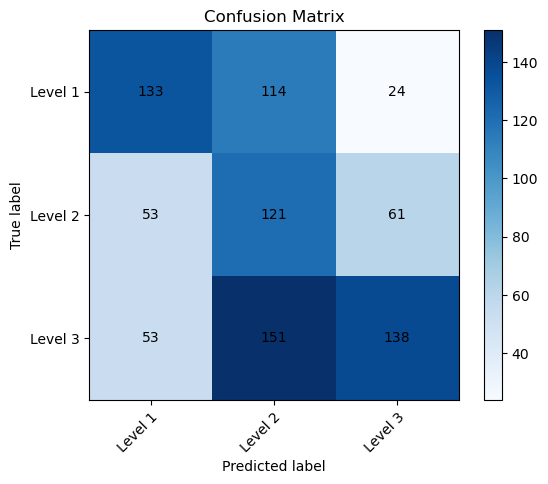

Feature Importance Rankings:
1. ADJ: 11.07960341464055
2. max_degree_of_equations: 10.125425278552992
3. VERB: 8.383691896142688
4. NOUN: 7.83375377792436
5. exp_count: 5.836838143204848
6. DET: 5.533489825850602
7. large_words_cat: 5.222672686982199
8. PUNCT: 4.794004353940354
9. number_of_digits: 4.649654882979555
10. ADP: 4.213523528556
11. number_of_numbers: 3.6267577359614833
12. fracs_count: 3.5513216795052482
13. average_word_length_cat: 3.143209804691787
14. word_count_cat: 2.847492411518817
15. words_per_sentence_cat: 2.624038621947279
16. NUM: 2.047404517668674
17. PROPN: 1.8589903380810273
18. AUX: 1.8572889522682563
19. SCONJ: 1.8012544121121206
20. PRON: 1.7940738859221217
21. CCONJ: 1.7699516322002482
22. neqlts_count: 1.036907101624198
23. X: 0.9146017159831528
24. ADV: 0.8386482404620544
25. eqlts_count: 0.5759852052467309
26. PART: 0.5739840436139483
27. SYM: 0.5702657923952257
28. sentence_count_cat: 0.3940859469615714
29. log_count: 0.2553670378623729
30. mod_count: 

In [48]:
model(data4)

Level 2    1540
Level 1     955
Level 3     893
Name: level, dtype: int64
Level 2    386
Level 1    239
Level 3    223
Name: level, dtype: int64
Best Parameters:  {'criterion': 'entropy', 'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'oob_score': True}
Best Score:  0.5259752595826634
train_evaluation:

              precision    recall  f1-score   support

     Level 1       0.48      0.72      0.58       641
     Level 2       0.86      0.57      0.68      2326
     Level 3       0.36      0.76      0.49       421

    accuracy                           0.62      3388
   macro avg       0.57      0.68      0.58      3388
weighted avg       0.72      0.62      0.64      3388

[[ 459  145   37]
 [ 471 1319  536]
 [  25   76  320]]

test_evaluation:

              precision    recall  f1-score   support

     Level 1       0.38      0.58      0.46       154
     Level 2       0.73      0.48      0.58       586
     Level 3       0.25      0.51    

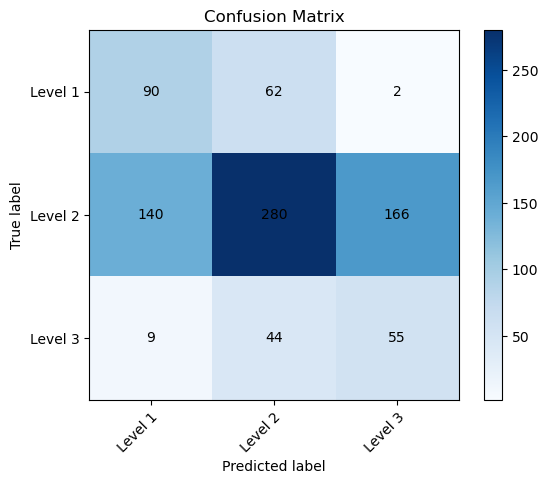

Feature Importance Rankings:
1. ADJ: 11.466525084571062
2. max_degree_of_equations: 9.263089092812866
3. NOUN: 6.578960197484831
4. VERB: 6.339510362659058
5. DET: 5.534796343567592
6. number_of_digits: 5.507311445316582
7. exp_count: 5.4427862003630345
8. PUNCT: 5.072439558085373
9. large_words_cat: 4.663089391065823
10. number_of_numbers: 4.1283659800425285
11. ADP: 3.7375896140631317
12. word_count_cat: 3.6748983338621666
13. words_per_sentence_cat: 3.414965696508783
14. average_word_length_cat: 2.903548928142413
15. AUX: 2.7516937753052573
16. SCONJ: 2.2315715189433467
17. fracs_count: 2.2153734587069565
18. CCONJ: 2.11488875055384
19. ADV: 1.957313671085124
20. PROPN: 1.9096281349598347
21. NUM: 1.828252414615318
22. PRON: 1.6657530860702552
23. neqlts_count: 1.640654667981081
24. eqlts_count: 0.8190013889089486
25. PART: 0.7637636348205584
26. X: 0.7505346382509939
27. mod_count: 0.542434935781863
28. SYM: 0.5321642063563767
29. sentence_count_cat: 0.4647545372373706
30. log_coun

In [49]:
model(data4, use_smote_technique=0)

## Experiment 5

Consider the following features

1. Categorised linguistic features
2. Numerical Math features
3. POS features
4. Math vocab

In [56]:
data5 = math_problems[LINGUISTIC_CAT_FEATURES + MATH_NUM_FEATURES + POS_FEATURES + MATH_VOCAB_FEATURES + TARGET_FEATURE]

Level 2    1540
Level 1     955
Level 3     893
Name: level, dtype: int64
Level 2    386
Level 1    239
Level 3    223
Name: level, dtype: int64
Class distribution before SMOTE: Counter({'Level 2': 1540, 'Level 1': 955, 'Level 3': 893})
Class distribution after SMOTE: Counter({'Level 2': 1540, 'Level 1': 1540, 'Level 3': 1540})
Best Parameters:  {'criterion': 'entropy', 'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'oob_score': True}
Best Score:  0.5538961038961039
train_evaluation:

              precision    recall  f1-score   support

     Level 1       0.80      0.65      0.72      1895
     Level 2       0.39      0.67      0.49       905
     Level 3       0.76      0.64      0.69      1820

    accuracy                           0.65      4620
   macro avg       0.65      0.65      0.64      4620
weighted avg       0.70      0.65      0.67      4620

[[1236  438  221]
 [ 150  602  153]
 [ 154  500 1166]]

test_evaluation:

              p

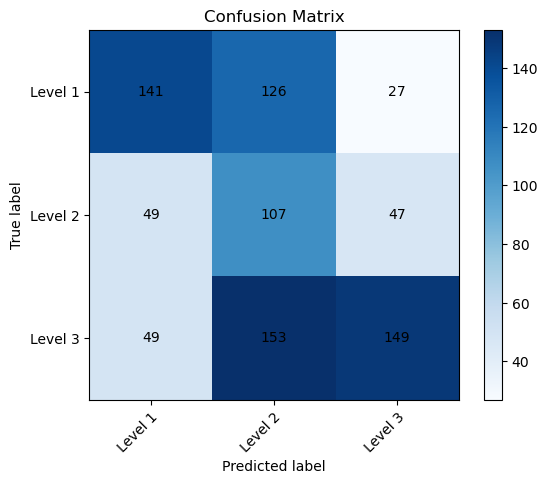

Feature Importance Rankings:
1. ADJ: 10.364150504439499
2. max_degree_of_equations: 9.082937456461263
3. VERB: 7.979050297499716
4. large_words_cat: 7.909546470754708
5. exp_count: 5.615614224486985
6. number_of_math_vocab: 5.608009762624225
7. NOUN: 5.575071669207052
8. PUNCT: 5.010739509959938
9. number_of_digits: 3.9223799866697044
10. word_count_cat: 3.77918105817311
11. NUM: 3.561746678928733
12. number_of_numbers: 3.3214054252173617
13. DET: 3.1830685001645502
14. words_per_sentence_cat: 2.934467278808143
15. AUX: 2.5390540356019105
16. ADP: 2.53739772404228
17. SCONJ: 2.50259105080927
18. fracs_count: 2.382651986335046
19. average_word_length_cat: 2.086250286958958
20. PRON: 1.6246955169893667
21. CCONJ: 1.5649675656444744
22. PROPN: 1.377649367570732
23. neqlts_count: 1.2270996427938063
24. ADV: 1.177790965002874
25. eqlts_count: 0.9215617013462888
26. PART: 0.6353923997199804
27. SYM: 0.6317527652342941
28. sentence_count_cat: 0.3016900235875476
29. X: 0.2937985783632818
30. m

In [57]:
model(data5)

Level 2    1540
Level 1     955
Level 3     893
Name: level, dtype: int64
Level 2    386
Level 1    239
Level 3    223
Name: level, dtype: int64


Best Parameters:  {'criterion': 'gini', 'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'oob_score': True}
Best Score:  0.5183065145117929
train_evaluation:

              precision    recall  f1-score   support

     Level 1       0.49      0.71      0.58       652
     Level 2       0.87      0.57      0.69      2343
     Level 3       0.35      0.80      0.49       393

    accuracy                           0.63      3388
   macro avg       0.57      0.70      0.59      3388
weighted avg       0.74      0.63      0.65      3388

[[ 466  145   41]
 [ 466 1339  538]
 [  23   56  314]]

test_evaluation:

              precision    recall  f1-score   support

     Level 1       0.36      0.59      0.45       147
     Level 2       0.76      0.49      0.59       605
     Level 3       0.22      0.52      0.31        96

    accuracy                           0.51       848
   macro avg       0.45      0.53      0.45       848
weighted avg       0.6

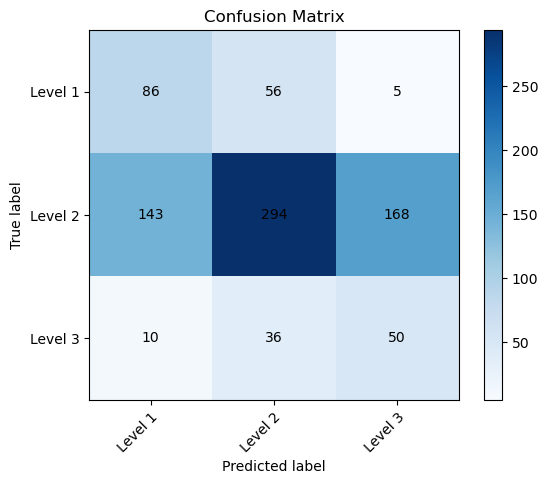

Feature Importance Rankings:
1. ADJ: 8.95384045453295
2. large_words_cat: 7.187503436454036
3. number_of_math_vocab: 6.3485567636272835
4. VERB: 6.250981985623924
5. max_degree_of_equations: 5.906113250427129
6. exp_count: 5.64646298287815
7. number_of_digits: 5.418021978587236
8. PUNCT: 4.975003010958911
9. NOUN: 4.4031565247059286
10. ADP: 4.097449370647633
11. DET: 3.9828318977234316
12. number_of_numbers: 3.818136476729001
13. words_per_sentence_cat: 3.3072834546408783
14. NUM: 3.1146802495680244
15. AUX: 2.826769728720077
16. word_count_cat: 2.6898578968864144
17. fracs_count: 2.612005555304301
18. neqlts_count: 2.3186978326148635
19. PRON: 2.216099349672485
20. CCONJ: 2.181517082771972
21. average_word_length_cat: 2.0408962462172284
22. PROPN: 1.7020229888328167
23. SCONJ: 1.6683888008010694
24. ADV: 1.602671196462643
25. eqlts_count: 1.0049450466213075
26. SYM: 0.8048069494980667
27. sentence_count_cat: 0.7437648530066481
28. mod_count: 0.6534179101411025
29. X: 0.64334423852887

In [58]:
model(data5, use_smote_technique=0)

## Experiment 6

Consider the following features
1. Math (cat/Num)
2. cohmetrix

In [70]:
cohmetrix = pd.read_csv("../Data/cohmetrix_final.csv")
print("Shape of cohmetric features: ", cohmetrix.shape)

math_data = math_problems[['problem']+ MATH_NUM_FEATURES + TARGET_FEATURE]

print("math features shape: ", math_data.shape)

data6 = pd.merge(cohmetrix,math_data, on='problem', how='inner')
data6.drop(columns=['problem'], inplace=True)

print("final dataframe shape: ", data6.shape)

Shape of cohmetric features:  (3900, 107)
math features shape:  (4236, 11)
final dataframe shape:  (3584, 116)


In [71]:
data6.isnull().sum()

DESPC                      0
DESSC                      0
DESWC                      0
DESPL                      0
DESPLd                     0
                          ..
neqlts_count               0
max_degree_of_equations    0
number_of_digits           0
number_of_numbers          0
level                      0
Length: 116, dtype: int64

In [69]:
data6.to_csv("checking.csv", index=False)

Level 2    1287
Level 1     859
Level 3     721
Name: level, dtype: int64
Level 2    322
Level 1    215
Level 3    180
Name: level, dtype: int64
Class distribution before SMOTE: Counter({'Level 2': 1287, 'Level 1': 859, 'Level 3': 721})
Class distribution after SMOTE: Counter({'Level 2': 1287, 'Level 3': 1287, 'Level 1': 1287})
Best Parameters:  {'criterion': 'gini', 'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'oob_score': True}
Best Score:  0.5711074543029311
train_evaluation:

              precision    recall  f1-score   support

     Level 1       0.79      0.74      0.76      1367
     Level 2       0.56      0.73      0.63       979
     Level 3       0.82      0.69      0.75      1515

    accuracy                           0.72      3861
   macro avg       0.72      0.72      0.72      3861
weighted avg       0.74      0.72      0.72      3861

[[1012  256   99]
 [ 127  716  136]
 [ 148  315 1052]]

test_evaluation:

              pre

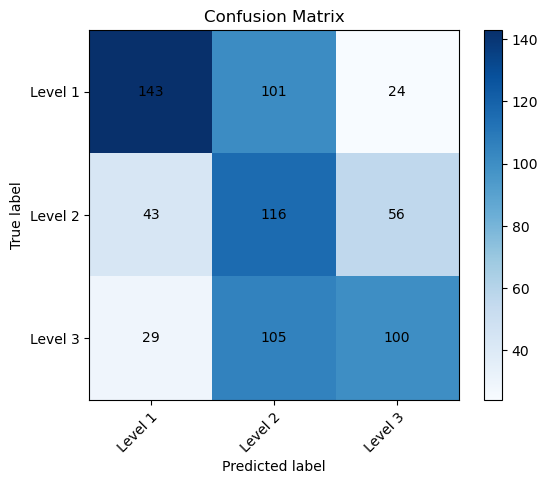

Feature Importance Rankings:
1. DESWC: 6.5374934624990155
2. max_degree_of_equations: 4.788454888589052
3. DESSL: 4.371928444723982
4. WRDMEAc: 2.7945007657269665
5. LDVOCD: 2.343585751153634
6. SYNLE: 2.330453651694621
7. PCSYNp: 2.2421170218773154
8. LDTTRc: 2.2408242077006557
9. SYNMEDwrd: 2.2030349960597935
10. WRDADJ: 2.0831405293634715
11. WRDIMGc: 2.005456210290424
12. WRDPOLc: 1.8325404364698712
13. PCSYNz: 1.8267238267740384
14. WRDHYPn: 1.8108126620490026
15. RDFKGL: 1.667901494738193
16. PCTEMPz: 1.6220326574875752
17. CNCAll: 1.5788160271071814
18. PCCNCz: 1.5686933478374558
19. PCCNCp: 1.5140609982758715
20. WRDFRQmc: 1.5092727024426484
21. exp_count: 1.4209089153476149
22. SMCAUSr: 1.3714326392816425
23. PCREFz: 1.352767637031429
24. DESWLlt: 1.3369001636849593
25. LDMTLD: 1.31439261164969
26. WRDCNCc: 1.2998314423799395
27. WRDHYPnv: 1.2909300345525319
28. PCNARz: 1.2884946368687418
29. PCCONNp: 1.2747279936484617
30. DESWLsyd: 1.2480843417697667
31. DRPP: 1.208416780690

In [72]:
model(data6)

Level 2    1287
Level 1     859
Level 3     721
Name: level, dtype: int64
Level 2    322
Level 1    215
Level 3    180
Name: level, dtype: int64
Best Parameters:  {'criterion': 'gini', 'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'oob_score': True}
Best Score:  0.5043593532419991
train_evaluation:

              precision    recall  f1-score   support

     Level 1       0.44      0.79      0.57       477
     Level 2       0.92      0.56      0.70      2113
     Level 3       0.31      0.81      0.45       277

    accuracy                           0.62      2867
   macro avg       0.56      0.72      0.57      2867
weighted avg       0.78      0.62      0.65      2867

[[ 378   78   21]
 [ 455 1182  476]
 [  26   27  224]]

test_evaluation:

              precision    recall  f1-score   support

     Level 1       0.33      0.57      0.42       125
     Level 2       0.79      0.48      0.60       535
     Level 3       0.18      0.58      0

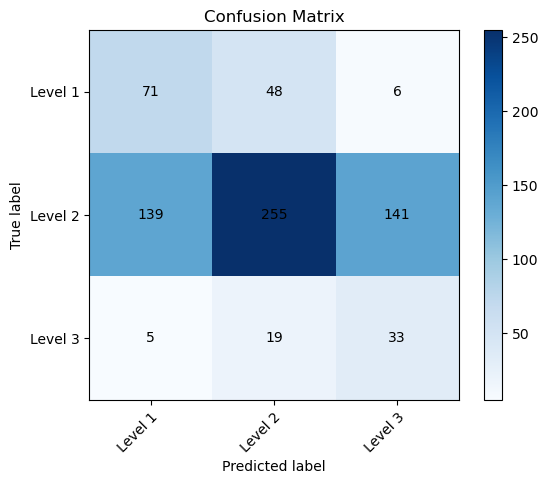

Feature Importance Rankings:
1. DESWC: 5.282132293801959
2. WRDMEAc: 4.241763438895178
3. CNCAll: 2.3641856268116648
4. WRDHYPnv: 2.289811672818282
5. WRDIMGc: 2.288514380006647
6. WRDCNCc: 2.1652485832162798
7. DESWLsyd: 2.1336229441445527
8. DESSL: 2.122684639387772
9. DESWLlt: 2.0863461922900495
10. DESWLltd: 2.0754100392740193
11. PCSYNp: 1.9897419433866206
12. PCVERBz: 1.9846754381700398
13. SMCAUSr: 1.9503743369081104
14. PCTEMPz: 1.9031067378956923
15. WRDPRO: 1.9007304077740488
16. WRDHYPv: 1.6696539519534432
17. PCCNCp: 1.5859450390256962
18. LDTTRc: 1.5774819610163193
19. PCCONNp: 1.4670236416464972
20. PCREFz: 1.443549047790781
21. DESWLsy: 1.4425743433619669
22. WRDPOLc: 1.4247374602186107
23. WRDADV: 1.4189642228038577
24. WRDAOAc: 1.4141793882463591
25. PCNARz: 1.3591719933725612
26. RDL2: 1.3330781234196425
27. WRDFAMc: 1.3180971071033118
28. PCCONNz: 1.3159654789044453
29. PCNARp: 1.3128794701619004
30. max_degree_of_equations: 1.307191611689978
31. DRAP: 1.307130385893

In [73]:
model(data6, use_smote_technique=0)

In [74]:
cohmetrix = pd.read_csv("../Data/cohmetrix_final.csv")
print("Shape of cohmetric features: ", cohmetrix.shape)

math_data = math_problems[['problem']+ MATH_CAT_FEATURES + TARGET_FEATURE]

print("math features shape: ", math_data.shape)

data6 = pd.merge(cohmetrix,math_data, on='problem', how='inner')
data6.drop(columns=['problem'], inplace=True)

print("final dataframe shape: ", data6.shape)

Shape of cohmetric features:  (3900, 107)
math features shape:  (4236, 8)
final dataframe shape:  (3584, 113)


Level 2    1287
Level 1     859
Level 3     721
Name: level, dtype: int64
Level 2    322
Level 1    215
Level 3    180
Name: level, dtype: int64
Class distribution before SMOTE: Counter({'Level 2': 1287, 'Level 1': 859, 'Level 3': 721})
Class distribution after SMOTE: Counter({'Level 2': 1287, 'Level 3': 1287, 'Level 1': 1287})
Best Parameters:  {'criterion': 'gini', 'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'oob_score': True}
Best Score:  0.5698101066432513
train_evaluation:

              precision    recall  f1-score   support

     Level 1       0.72      0.74      0.73      1265
     Level 2       0.59      0.68      0.63      1121
     Level 3       0.81      0.71      0.75      1475

    accuracy                           0.71      3861
   macro avg       0.71      0.71      0.71      3861
weighted avg       0.72      0.71      0.71      3861

[[ 932  250   83]
 [ 196  761  164]
 [ 159  276 1040]]

test_evaluation:

              pre

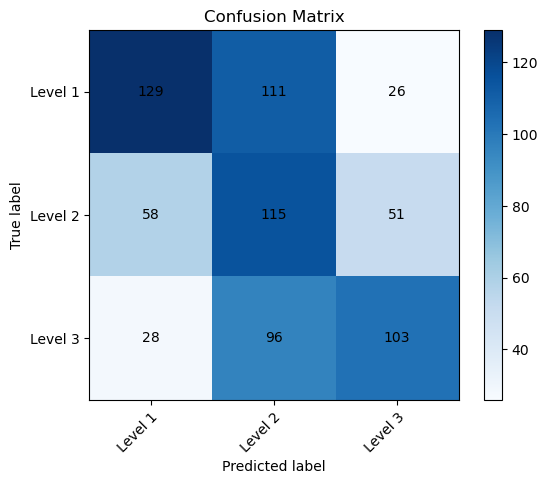

Feature Importance Rankings:
1. CNCAll: 3.8441446233876264
2. DESWC: 3.8361561371258337
3. DESSL: 3.783086737968401
4. SYNMEDwrd: 3.3197528123362083
5. LDMTLD: 3.01711648305561
6. WRDIMGc: 2.768294927864795
7. WRDADJ: 2.6780535930087064
8. WRDPRO: 2.407400646506534
9. LSAGN: 2.3998644628801467
10. SYNLE: 2.3801294361693017
11. WRDCNCc: 2.3186677856463986
12. DESWLltd: 2.1618004148717094
13. WRDPOLc: 2.107969233216055
14. WRDMEAc: 2.095612068076017
15. PCTEMPz: 2.0763864609735556
16. has_exp: 2.0163407764143444
17. WRDFRQmc: 1.9461562338489329
18. SMTEMP: 1.873453677861087
19. LDVOCD: 1.8125001361899131
20. DESSLd: 1.7348546009639747
21. LDTTRa: 1.6856699560391222
22. RDL2: 1.6362610859538316
23. DESWLsyd: 1.392752512834894
24. SMINTEp: 1.3446684526566661
25. PCREFz: 1.3144809093898888
26. WRDHYPn: 1.298064102413628
27. DRNEG: 1.2915806271827932
28. PCSYNz: 1.2504995637327239
29. WRDAOAc: 1.225181863712466
30. WRDHYPnv: 1.217593414624349
31. PCNARz: 1.1712335832059908
32. DESWLlt: 1.165

In [75]:
model(data6)

Level 2    1287
Level 1     859
Level 3     721
Name: level, dtype: int64
Level 2    322
Level 1    215
Level 3    180
Name: level, dtype: int64
Best Parameters:  {'criterion': 'entropy', 'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 10, 'oob_score': True}
Best Score:  0.5039993675927784
train_evaluation:

              precision    recall  f1-score   support

     Level 1       0.48      0.79      0.60       528
     Level 2       0.91      0.57      0.70      2055
     Level 3       0.32      0.81      0.46       284

    accuracy                           0.63      2867
   macro avg       0.57      0.72      0.59      2867
weighted avg       0.77      0.63      0.66      2867

[[ 416   86   26]
 [ 425 1166  464]
 [  18   35  231]]

test_evaluation:

              precision    recall  f1-score   support

     Level 1       0.38      0.57      0.46       145
     Level 2       0.77      0.49      0.60       504
     Level 3       0.22      0.57   

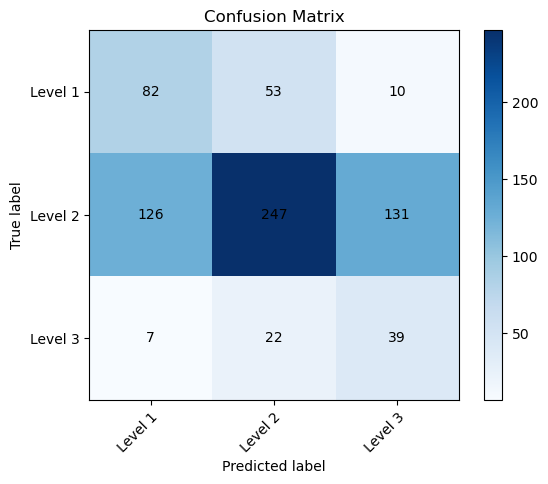

Feature Importance Rankings:
1. DESWLltd: 5.203220870490529
2. WRDADJ: 4.263959430455949
3. CNCAll: 3.7134670054741075
4. RDL2: 3.180369020888194
5. DESSL: 2.963538191639605
6. DESWC: 2.72231003959091
7. PCSYNp: 2.553456739946768
8. WRDCNCc: 2.3435952104766855
9. PCNARz: 2.075425772920986
10. DESWLlt: 2.0211737947423756
11. has_exp: 2.003678525156255
12. DRNP: 2.0029736424286684
13. WRDPOLc: 1.9472328836529478
14. WRDIMGc: 1.9410062086918822
15. SMTEMP: 1.8892229855410498
16. SMINTEp: 1.863027045052024
17. PCVERBz: 1.6828984513916048
18. DESSLd: 1.6687189348490377
19. LDVOCD: 1.6200272172586083
20. PCTEMPz: 1.6138846084983098
21. DESWLsy: 1.6127653956889607
22. DESWLsyd: 1.5941357023959843
23. WRDPRO: 1.5082446678268857
24. WRDADV: 1.5020151953992322
25. PCSYNz: 1.385241332161528
26. PCCONNp: 1.3678515339274704
27. DRPP: 1.327373568745464
28. WRDHYPnv: 1.305931911658417
29. WRDHYPv: 1.2575193158808016
30. DRVP: 1.2571378113131946
31. SYNMEDwrd: 1.2458524650050098
32. DRAP: 1.1993215317

In [76]:
model(data6, use_smote_technique=0)